In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xml.etree.ElementTree as ET
import os
import cv2
import tensorflow as tf
from wordcloud import WordCloud
import re
from collections import defaultdict
import itertools
from collections import Counter

In [2]:
directory = 'ecgen-radiology'

In [3]:
# extracting data from the xml documents
img = []
img_impression = []
img_finding = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
                                        
        for p_image in root.findall('parentImage'):
            
            img.append(p_image.get('id'))
            img_finding.append(finding)

100%|█████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:36<00:00, 108.73it/s]


In [4]:
dataset = pd.DataFrame()
dataset['Image_path'] = img
dataset['Finding'] = img_finding

In [5]:
dataset.head(10)

,Image_path,Finding
0,CXR1_1_IM-0001-3001,The cardiac silhouette and mediastinum size ar...
1,CXR1_1_IM-0001-4001,The cardiac silhouette and mediastinum size ar...
2,CXR10_IM-0002-1001,The cardiomediastinal silhouette is within nor...
3,CXR10_IM-0002-2001,The cardiomediastinal silhouette is within nor...
4,CXR100_IM-0002-1001,Both lungs are clear and expanded. Heart and m...
5,CXR100_IM-0002-2001,Both lungs are clear and expanded. Heart and m...
6,CXR1000_IM-0003-1001,There is XXXX increased opacity within the rig...
7,CXR1000_IM-0003-2001,There is XXXX increased opacity within the rig...
8,CXR1000_IM-0003-3001,There is XXXX increased opacity within the rig...
9,CXR1001_IM-0004-1001,Interstitial markings are diffusely prominent ...


In [5]:
print('Dataset Shape:', dataset.shape)

Dataset Shape: (7470, 2)


In [6]:
def absolute_path(x):
    '''Makes the path absolute '''
    x = 'Scanned Images/'+ x + '.png'
    return x

In [7]:
dataset['Image_path'] = dataset['Image_path'].apply(lambda x : absolute_path(x)) # making the paths absolute

In [9]:
def image_desc_plotter(data, n, rep):  
    count = 1  
    fig = plt.figure(figsize=(10,20))

    if rep == 'finding':
        
        for filename in data['Image_path'].values[95:100]:   
        
            findings = list(data["Finding"].loc[data["Image_path"] == filename].values) 
            img = cv2.imread(filename)    
            ax = fig.add_subplot(n, 2 , count , xticks=[], yticks=[])  
            ax.imshow(img)     
            count += 1            
            ax = fig.add_subplot(n ,2 ,count)   
            plt.axis('off')     
            ax.plot()     
            ax.set_xlim(0,1)    
            ax.set_ylim(0, len(findings))  
            for i, f in enumerate(findings):   
                ax.text(0,i,f,fontsize=20)   
            count += 1 
        plt.show()
        
    else:
        print("Enter a valid String")
   

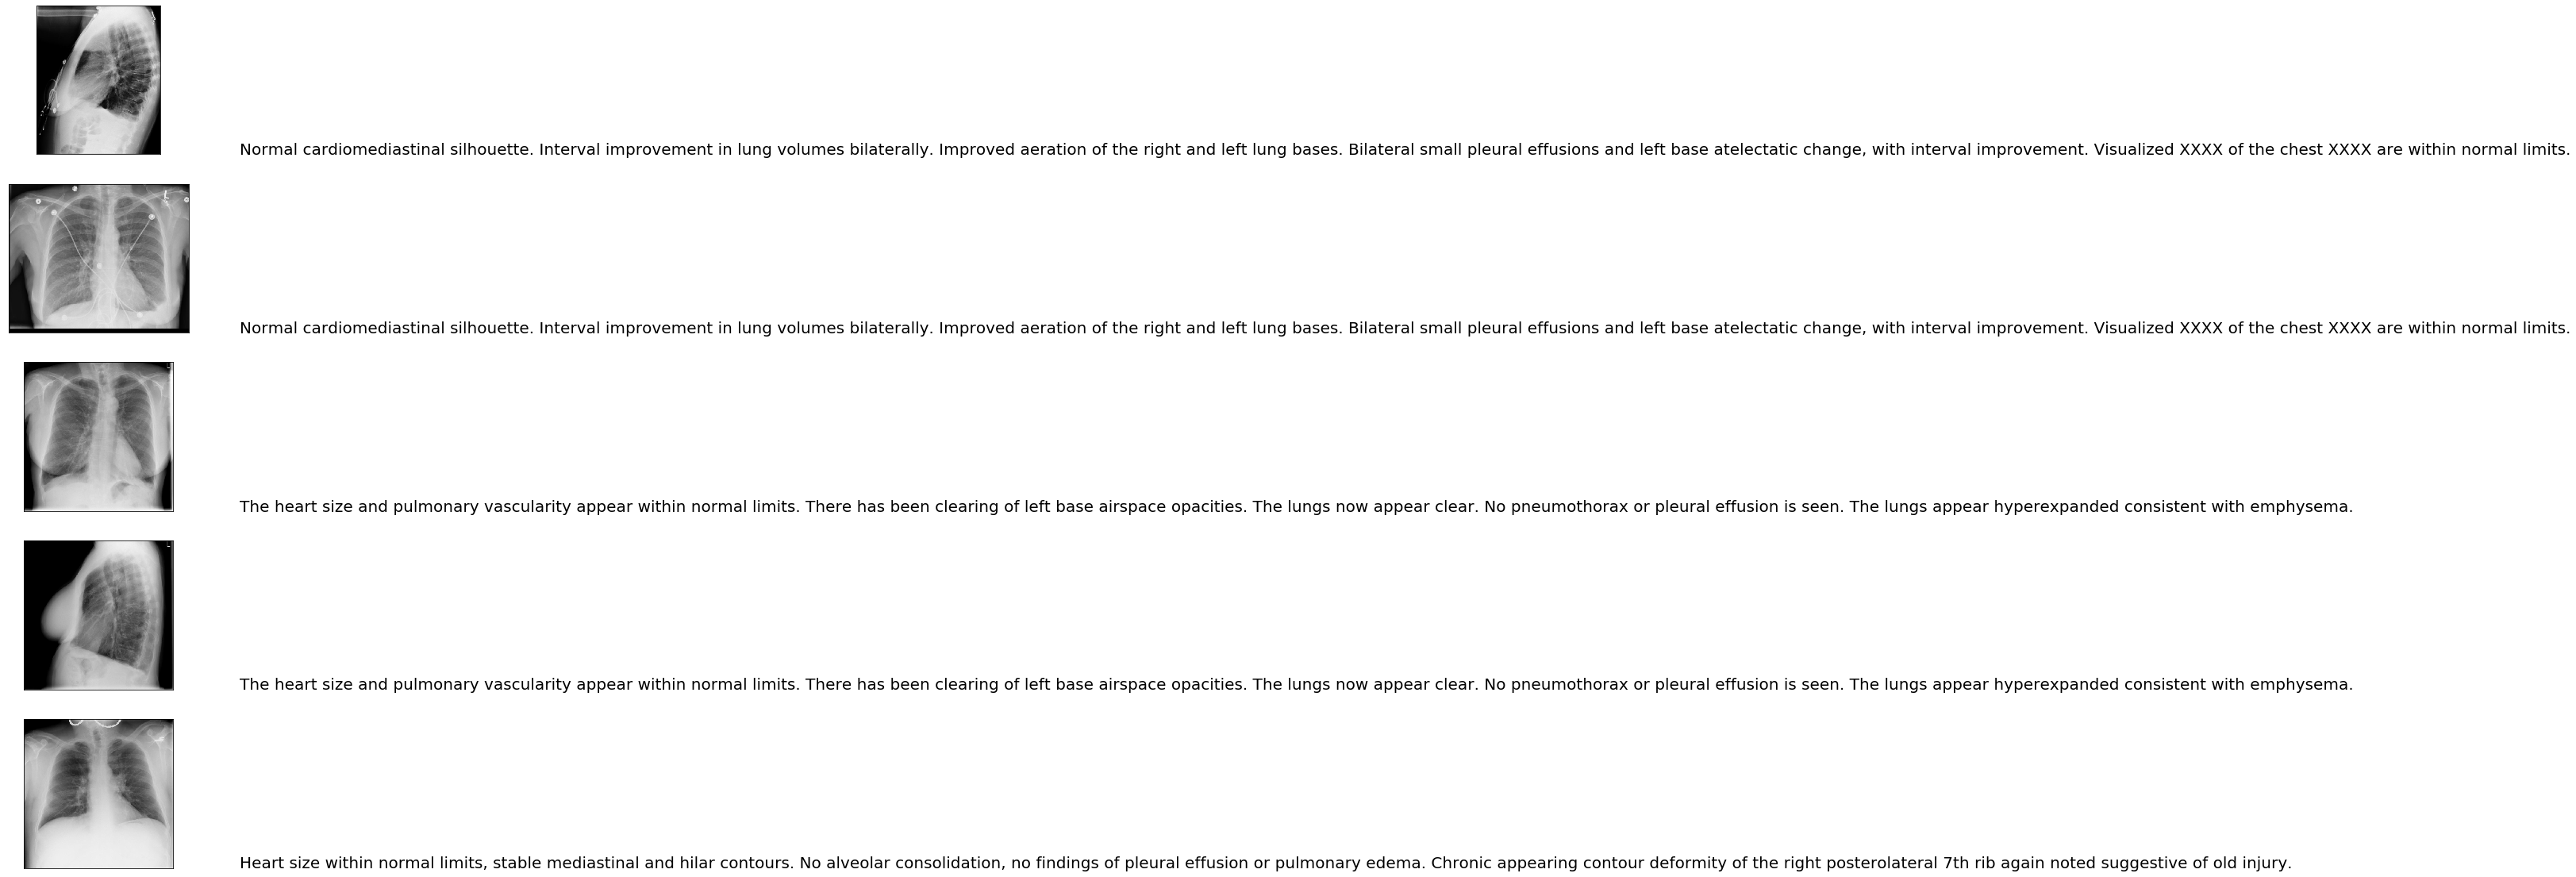

In [10]:
image_desc_plotter(dataset, 5, 'finding')

In [8]:
# loading the heights and widths of each image
h = []
w = []
for i in tqdm(np.unique(dataset['Image_path'].values)):
    img = cv2.imread(i)
    h.append(img.shape[0])
    w.append(img.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 7470/7470 [02:03<00:00, 60.27it/s]


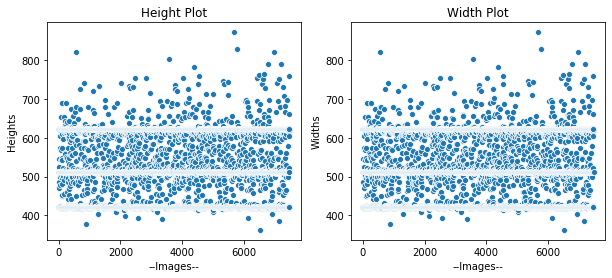

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Height Plot')
plt.ylabel('Heights')
plt.xlabel('--Images--')
sns.scatterplot(range(len(h)), h)
plt.subplot(122)
plt.title('Width Plot')
plt.ylabel('Widths')
plt.xlabel('--Images--')
sns.scatterplot(range(len(w)), h)

Images have different heights and widths, they will be resized into a common shape

In [13]:
print('Number of Unique Images:', dataset['Image_path'].nunique())

Number of Unique Images: 7470


In [14]:
# number of missing values
dataset.isnull().sum()

Image_path      0
Finding       997
dtype: int64

There are a total of 997 rows where 'findings' column has no value. We can simply drop them.

In [15]:
dataset = dataset.dropna(axis=0) # drop all missing value rows

In [16]:
dataset.isnull().sum()

Image_path    0
Finding       0
dtype: int64

In [17]:
print('New Shape of the Data:', dataset.shape)

New Shape of the Data: (6473, 2)


In [18]:
dataset.head(12)

,Image_path,Finding
0,Scanned Images/CXR1_1_IM-0001-3001.png,The cardiac silhouette and mediastinum size ar...
1,Scanned Images/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
2,Scanned Images/CXR10_IM-0002-1001.png,The cardiomediastinal silhouette is within nor...
3,Scanned Images/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
4,Scanned Images/CXR100_IM-0002-1001.png,Both lungs are clear and expanded. Heart and m...
5,Scanned Images/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
6,Scanned Images/CXR1000_IM-0003-1001.png,There is XXXX increased opacity within the rig...
7,Scanned Images/CXR1000_IM-0003-2001.png,There is XXXX increased opacity within the rig...
8,Scanned Images/CXR1000_IM-0003-3001.png,There is XXXX increased opacity within the rig...
9,Scanned Images/CXR1001_IM-0004-1001.png,Interstitial markings are diffusely prominent ...


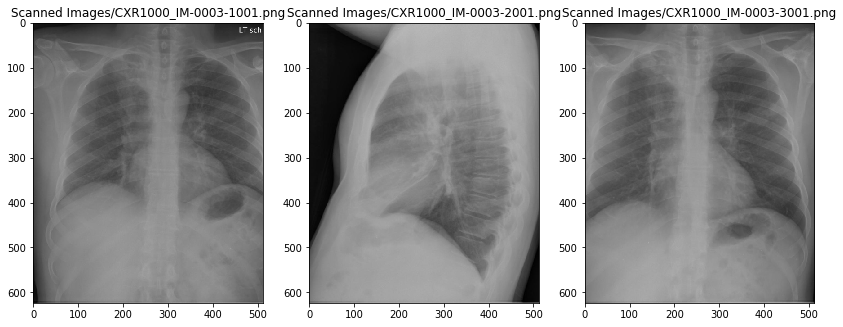

In [19]:
plt.figure(figsize=(14,7))
plt.subplot(131)
img1 = cv2.imread(dataset['Image_path'].values[6])
plt.imshow(img1)
plt.title(dataset['Image_path'].values[6])
plt.subplot(132)
img2 = cv2.imread(dataset['Image_path'].values[7])
plt.title(dataset['Image_path'].values[7])
plt.imshow(img2)
plt.subplot(133)
img3 = cv2.imread(dataset['Image_path'].values[8])
plt.title(dataset['Image_path'].values[8])
plt.imshow(img3)

In [20]:
dataset['Finding'].values[6], dataset['Finding'].values[7], dataset['Finding'].values[8]

('There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.',
 'There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.',
 'There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent foca

The above two findings are same since its of the same person. The images are also of the same person but scanned at different views.

### The dataset consists of multiple chest shots of the same person. The images of a same person has the same file name except the last 4 digits. Therefore that can be taken as the person ID.

In [21]:
# This creates 2 dictionaries with keys as the person id and the number of images and findings for that person. 
images = {}
findings = {}
for img, fin in dataset.values:
    a = img.split('-')
    a.pop(len(a)-1)
    a = '-'.join(e for e in a)
    if a not in images.keys():
        images[a] = 1
        findings[a] = fin
    else:
        images[a] += 1
        findings[a] = fin

In [22]:
images['Scanned Images/CXR1001_IM-0004'], findings['Scanned Images/CXR1001_IM-0004']

(2,
 'Interstitial markings are diffusely prominent throughout both lungs. Heart size is normal. Pulmonary XXXX normal.')

In [23]:
print('Total Number of Unique_IDs :', len(images.keys()))

Total Number of Unique_IDs : 3350


The dataset contains images of 3350 different people

Text(0.5, 0, 'Number of Individuals in the Data')

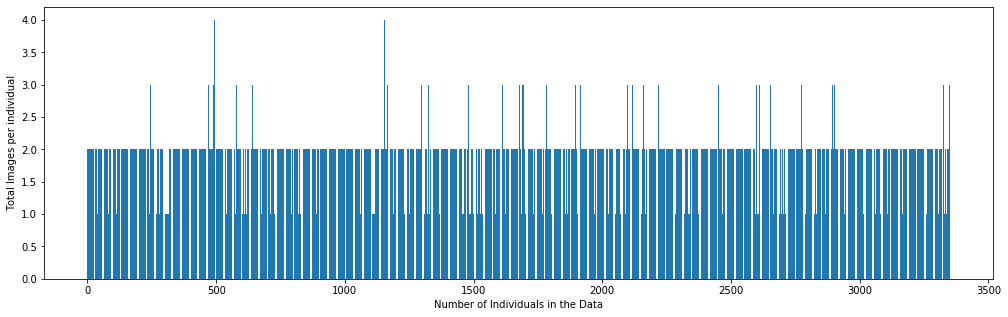

In [24]:
plt.figure(figsize=(17,5))
plt.bar(range(len(images.keys())), images.values())
plt.ylabel('Total Images per individual')
plt.xlabel('Number of Individuals in the Data')

As we can see there are multiple images corresponding to a single person. These are different chest scans at different views.
Most of the individuals have only 2 scans while the highest being 4.

In [25]:
one = 0
two = 0
three = 0
four = 0
for v in images.values():
    if v == 1:
        one +=1
    elif v == 2:
        two += 1
    elif v == 3:
        three += 1
    elif v == 4:
        four += 1
    else:
        print('Error')

In [26]:
one, two, three, four

(390, 2807, 143, 10)

The above variables one, two, three, four contains the total number of IDs with 1,2,3,4 number of images respectively.

In [27]:
image_per_person = defaultdict(list)  # creating a list of dictionary to store all the image paths corresponding to a person_id

In [28]:
for pid in images.keys():
    for img in dataset['Image_path'].values:
        if pid in img:
            image_per_person[pid].append(img)
        else:
            continue

In [29]:
image_per_person['Scanned Images/CXR1102_IM-0069']

['Scanned Images/CXR1102_IM-0069-12012.png',
 'Scanned Images/CXR1102_IM-0069-2001.png',
 'Scanned Images/CXR1102_IM-0069-3001.png',
 'Scanned Images/CXR1102_IM-0069-4004.png']

In [30]:
def load_image(file):
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [31]:
# just checking the ID which has 4 images
for k,v in images.items():
    if v == 4:
        print(k)
        break

Scanned Images/CXR1102_IM-0069


Text(0.5, 1.0, 'Scanned Images/CXR1102_IM-0069-4004.png')

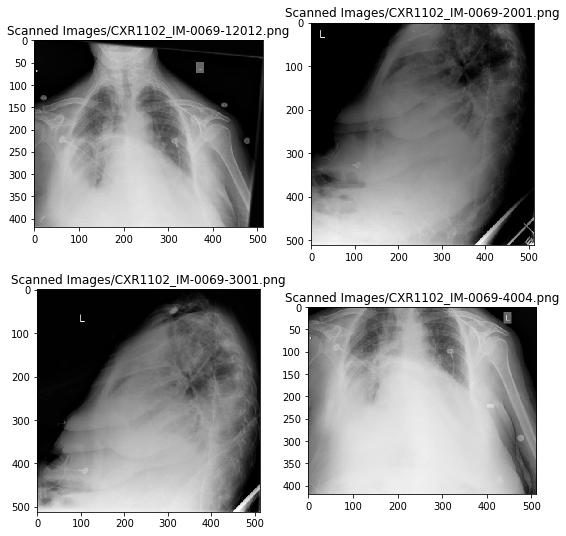

In [32]:
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-12012.png'))
plt.title('Scanned Images/CXR1102_IM-0069-12012.png')
plt.subplot(222)
plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-2001.png'))
plt.title('Scanned Images/CXR1102_IM-0069-2001.png')
plt.subplot(223)
plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-3001.png'))
plt.title('Scanned Images/CXR1102_IM-0069-3001.png')
plt.subplot(224)
plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-4004.png'))
plt.title('Scanned Images/CXR1102_IM-0069-4004.png')

2 side view and 2 front view images for the same ID

Sample chest scans of a person(4 images)

Now, we have multiple chest scans to produce a single report. Some person_ids have 1, some have 2 and the highest is 4. So we
can take pairs of those images as input. If it has only one image, then it can be replicated.

In [33]:
# new dataset
person_id, image1, image2, report = [],[],[],[]
for pid, imgs in image_per_person.items():   #contains pid and the images associated with that pid
    
    if len(imgs) == 1:
        image1.append(imgs[0])
        image2.append(imgs[0])
        person_id.append(pid)
        report.append(findings[pid])
    else:
        a = itertools.combinations(imgs, 2)
        for i in a:
            image1.append(i[0])
            image2.append(i[1])
            person_id.append(pid)
            report.append(findings[pid])

In [34]:
dataset = pd.DataFrame()
dataset['Person_id'] = person_id
dataset['Image1'] = image1
dataset['Image2'] = image2
dataset['Report'] = report

In [35]:
dataset.head()

,Person_id,Image1,Image2,Report
0,Scanned Images/CXR1_1_IM-0001,Scanned Images/CXR1_1_IM-0001-3001.png,Scanned Images/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
1,Scanned Images/CXR10_IM-0002,Scanned Images/CXR10_IM-0002-1001.png,Scanned Images/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
2,Scanned Images/CXR100_IM-0002,Scanned Images/CXR100_IM-0002-1001.png,Scanned Images/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
3,Scanned Images/CXR1000_IM-0003,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-2001.png,There is XXXX increased opacity within the rig...
4,Scanned Images/CXR1000_IM-0003,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-3001.png,There is XXXX increased opacity within the rig...


## Text Cleaning

In [68]:
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [69]:
def text_preprocessing(text):
    '''Combines all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [40]:
dataset['Report'] = text_preprocessing(dataset['Report'])

In [41]:
dataset.head()

,Person_id,Image1,Image2,Report
0,Scanned Images/CXR1_1_IM-0001,Scanned Images/CXR1_1_IM-0001-3001.png,Scanned Images/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...
1,Scanned Images/CXR10_IM-0002,Scanned Images/CXR10_IM-0002-1001.png,Scanned Images/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette within normal...
2,Scanned Images/CXR100_IM-0002,Scanned Images/CXR100_IM-0002-1001.png,Scanned Images/CXR100_IM-0002-2001.png,both lungs are clear and epanded . heart and ...
3,Scanned Images/CXR1000_IM-0003,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-2001.png,there increased opacity within the right upper...
4,Scanned Images/CXR1000_IM-0003,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-3001.png,there increased opacity within the right upper...


In [43]:
l = [len(e.split()) for e in dataset['Report'].values]  # Number of words in each report
# max(l) = 155

Text(0, 0.5, 'Number of words')

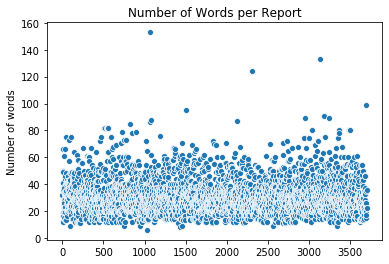

In [44]:
plt.title('Number of Words per Report')
sns.scatterplot(range(dataset.shape[0]), l)
plt.ylabel('Number of words')

Most of the reports contain word count below 100

In [45]:
l = []
for i in dataset['Report'].values:
    l.extend(i.split())

In [46]:
c = Counter(l)

In [73]:
words = []
count = []
for k,v in c.items():
    words.append(k)
    count.append(v)
words_count = list(zip(count, words))

In [79]:
top_50_words = sorted(words_count)[::-1][:50]
bottom_50_words = sorted(words_count)[:50]

([<matplotlib.axis.XTick at 0x251ebd64fc8>,
 <a list of 50 Text xticklabel objects>)

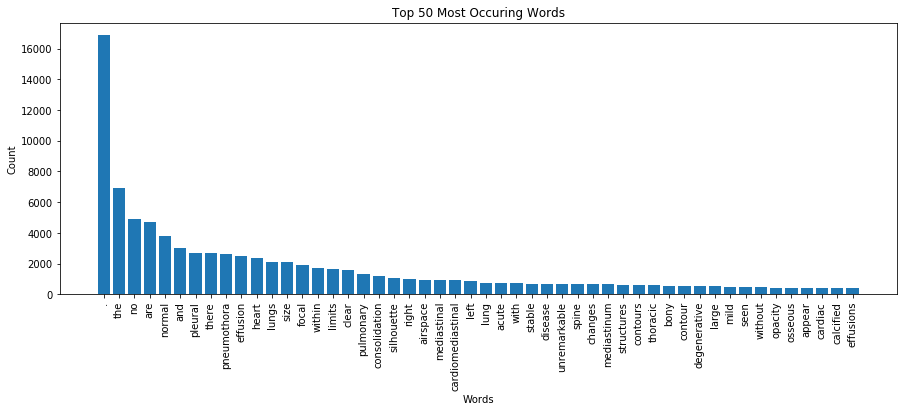

In [87]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in top_50_words])
plt.title('Top 50 Most Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in top_50_words], rotation=90)

([<matplotlib.axis.XTick at 0x251ed15ad08>,
 <a list of 50 Text xticklabel objects>)

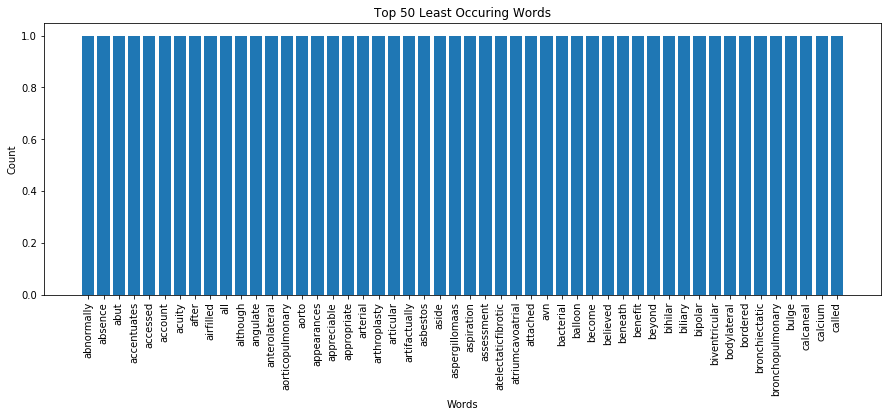

In [88]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in bottom_50_words])
plt.title('Top 50 Least Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in bottom_50_words], rotation=90)

In [48]:
w = WordCloud(height=1500, width=1500).generate(str(l))

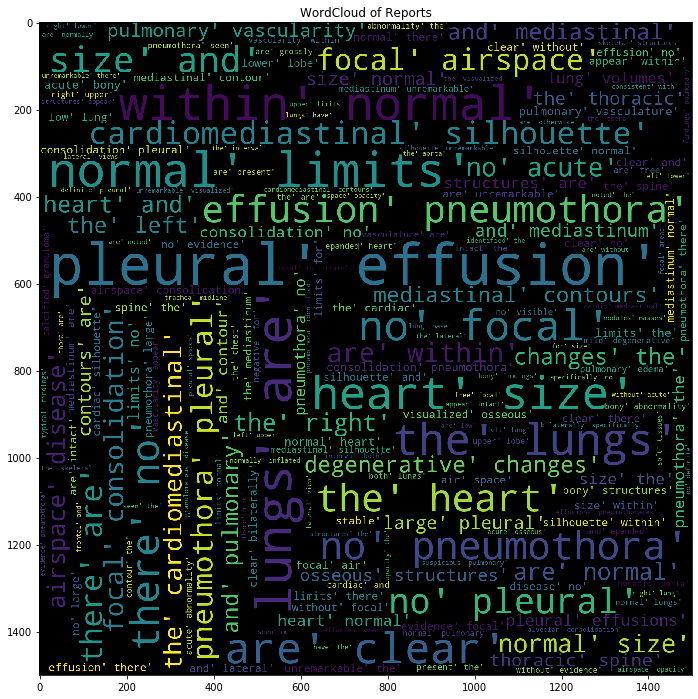

In [49]:
plt.figure(figsize=(12,12))
plt.title('WordCloud of Reports')
plt.imshow(w)

In [6]:
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [7]:
dataset['Report'] = dataset['Report'].apply(lambda x : remodelling(x))

In [8]:
#dataset.to_csv('Data.csv', index=False) -----> save the cleaned data(STRUCTURED DATA)